# Correção automática de provas

## Imports e outras inicializações

In [1]:
import warnings
import cv2
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
print(cv2.__version__)
warnings.filterwarnings('ignore')

4.5.2


## Abrindo imagens

(1758, 820, 3)


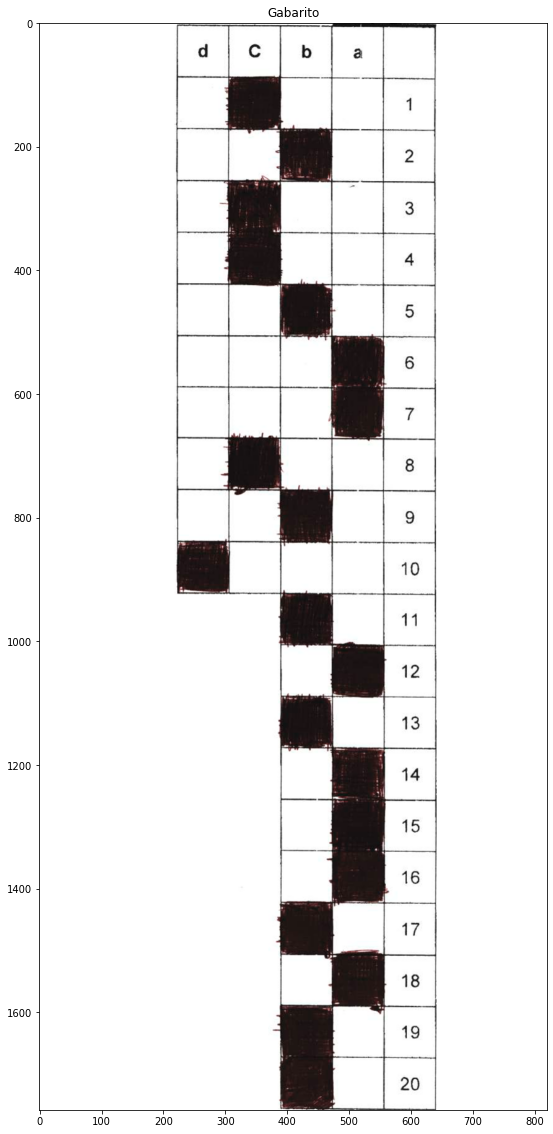

In [2]:
def abrir_imagens(img_caminho):
    imagem = cv2.imread(img_caminho, cv2.COLOR_BGR2RGB)
    if imagem is None:
        raise NameError('\nImagem não encontrada. Verifique se o caminho passado existe!')
    return imagem



imagem = abrir_imagens('./imagens/teste1.png')
print(imagem.shape)

plt.figure(figsize=(10, 20))
plt.title('Gabarito')
plt.imshow(imagem)
plt.show()

## Binarização e bordas

Converte para escala de cinza

(1758, 820)


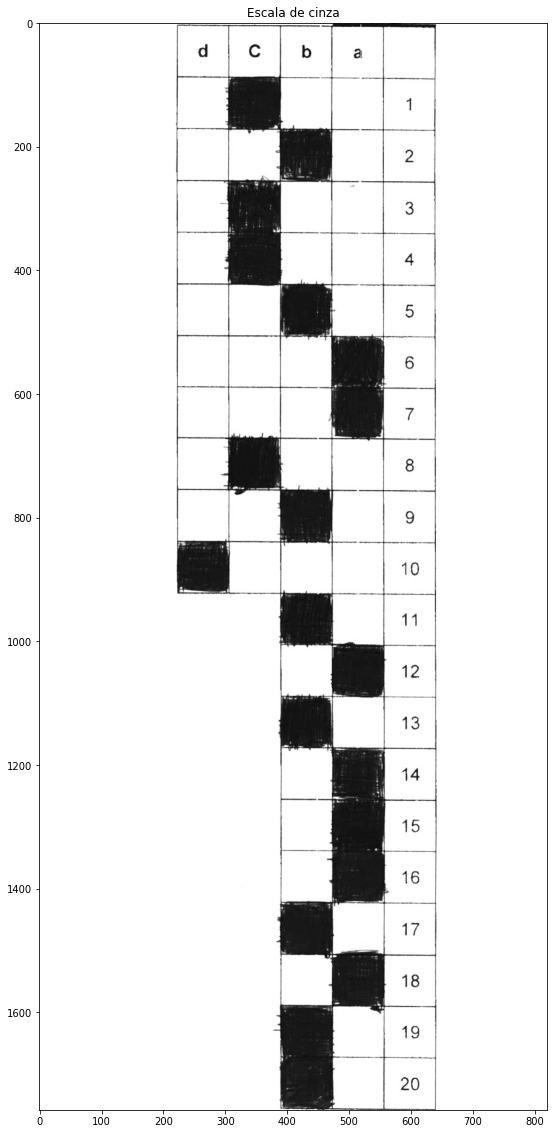

In [3]:
imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_RGB2GRAY)
print(imagem_gray.shape)

plt.figure(figsize=(10, 20))
plt.title('Escala de cinza')
plt.imshow(imagem_gray, cmap='Greys_r')
plt.show()

Converte para escala preto e branco e destaca as bordas

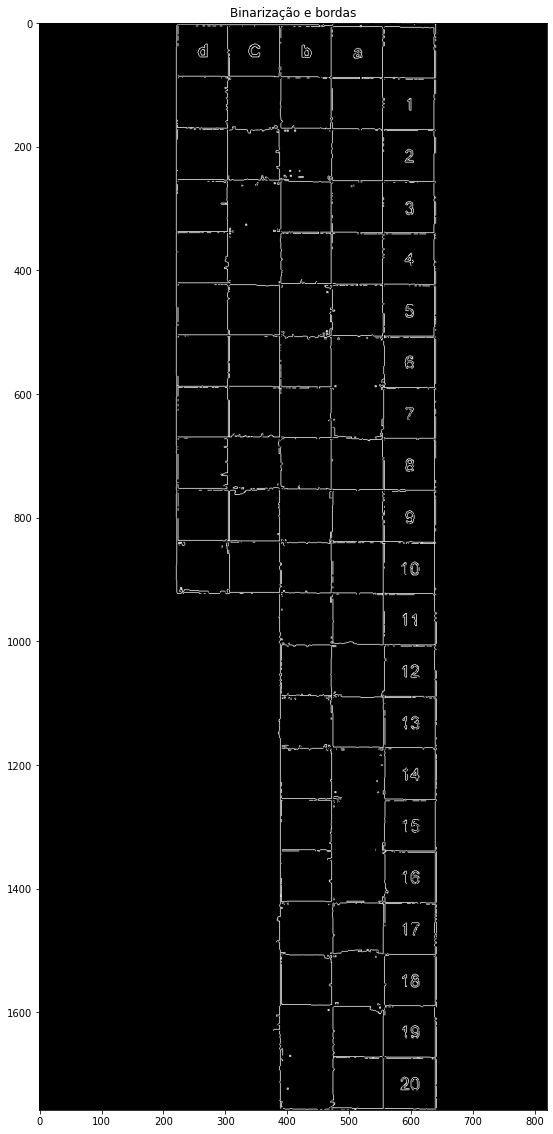

In [4]:
thresh, imagem_binaria = cv2.threshold(imagem_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imagem_com_borda = cv2.Canny(imagem_binaria, 100, 200)

plt.figure(figsize=(10, 20))
plt.title('Binarização e bordas')
plt.imshow(imagem_com_borda, cmap='Greys_r')
plt.show()

## Filtros morfológicos

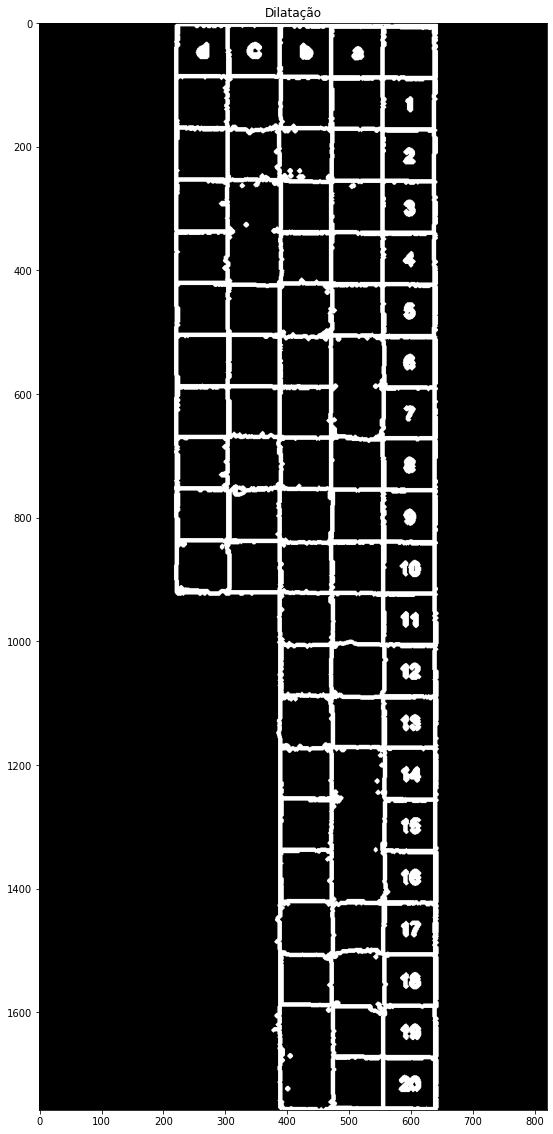

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
operacao_dilatar = cv2.morphologyEx(imagem_com_borda, cv2.MORPH_DILATE, kernel, iterations=3)

plt.figure(figsize=(10, 20))
plt.title('Dilatação')
plt.imshow(operacao_dilatar, cmap='Greys_r')
plt.show()

## Remoção de ruídos

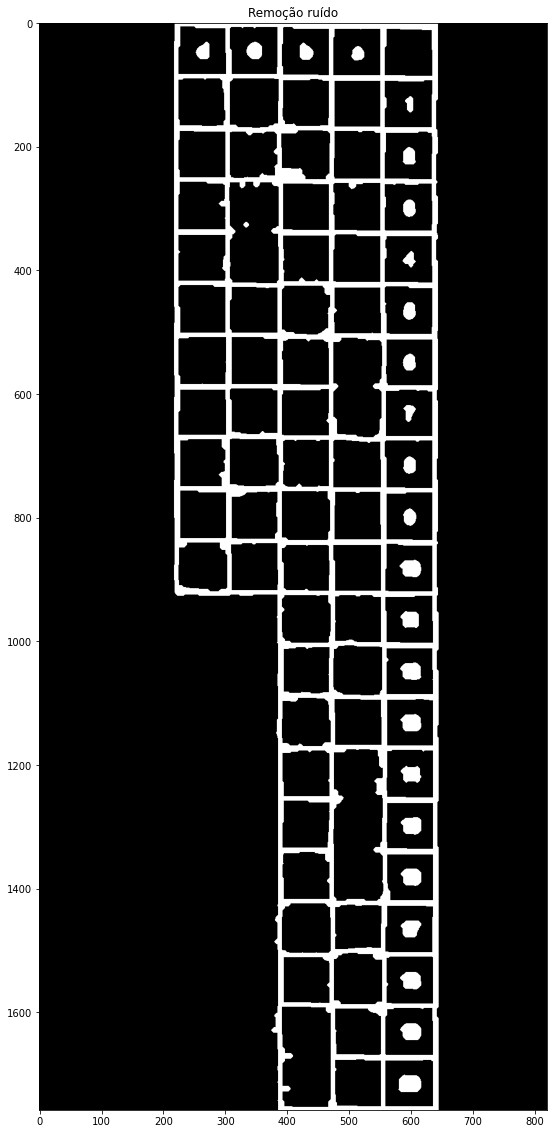

In [8]:
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
operacao_close = cv2.morphologyEx(operacao_dilatar, cv2.MORPH_CLOSE, kernel_rect, iterations=3)
operacao_open = cv2.morphologyEx(operacao_close, cv2.MORPH_OPEN, kernel_rect, iterations=1)

plt.figure(figsize=(10, 20))
plt.title('Remoção ruído')
plt.imshow(operacao_close, cmap='Greys_r')
plt.show()

## Estratégia para encontrar linhas

In [ ]:
def hough_para_cartesiano(raio, theta):
    return x, y

In [13]:
l_linhas = cv2.HoughLines(operacao_open, 1, np.pi/180, 80)
for linha in l_linhas[:5]:
    for raio, theta in linha:
        print(raio, theta)

387.0 0.0
471.0 0.0
556.0 0.0
636.0 0.0
223.0 0.0
